In [1]:

import sys
import os
from HRI_retarget import DATA_ROOT


import torch
from tqdm import tqdm
import pickle

import numpy as np

from HRI_retarget import ROOT
from HRI_retarget.utils.vis.bvh_vis import Get_bvh_joint_global_pos, Get_bvh_joint_pos_and_Rot, calc_relative_transform
from HRI_retarget.utils.vis.kinematic_vis import vis_kinematic_result
from HRI_retarget.model.g1_inspirehands import G1_Inspirehands_Motion_Model
from HRI_retarget.config.joint_mapping import MOTION_CAPTURE_LINKS, MOTION_CAPTURE_G1_INSPIREHANDS_CORRESPONDENCE, \
    MOTION_CAPTURE_LEFT_HAND_LINK, MOTION_CAPTURE_RIGHT_HAND_LINK
from HRI_retarget.utils.vis.bvh_vis import Rx, Ry, Rz

import matplotlib.pyplot as plt
from dex_retargeting.retargeting_config import RetargetingConfig
from pathlib import Path
import yaml
import pandas as pd

# rot = np.eye(3)
rot = np.array([[0,-1,0],[1,0,0],[0,0,1]])
left_hand_to_inspire = np.array([[1,0,0],[0,0,1],[0,-1,0]])
right_hand_to_inspire = np.array([[-1,0,0],[0,0,1],[0,1,0]])
config_file_path = os.path.join(DATA_ROOT, "resources/robots/g1_inspirehands/inspire_hand.yml")
default_urdf_dir = os.path.join(DATA_ROOT,"resources/robots/g1_inspirehands")

In [2]:
filename = "/home/chenghuailin/hri-retargetting/data/motion/human/motion_capture/Jappelio_rays_Skeleton.bvh"
bvh_joint_pos_local_coord, bvh_joint_rot_local_coord = Get_bvh_joint_pos_and_Rot(filename, link_list = MOTION_CAPTURE_LINKS)
# bvh_joint_global_coord = Get_bvh_joint_global_pos(filename, link_list=MOTION_CAPTURE_LINKS)
bvh_joint_local_coord, bvh_joint_rot_local_coord = Get_bvh_joint_pos_and_Rot(filename, link_list = MOTION_CAPTURE_LINKS)


joints:  ['Hips', 'Spine', 'Spine1', 'Neck', 'Head', 'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand', 'LeftHandThumb1', 'LeftHandThumb2', 'LeftHandThumb3', 'LeftHandIndex1', 'LeftHandIndex2', 'LeftHandIndex3', 'LeftHandMiddle1', 'LeftHandMiddle2', 'LeftHandMiddle3', 'LeftHandRing1', 'LeftHandRing2', 'LeftHandRing3', 'LeftHandPinky1', 'LeftHandPinky2', 'LeftHandPinky3', 'RightShoulder', 'RightArm', 'RightForeArm', 'RightHand', 'RightHandThumb1', 'RightHandThumb2', 'RightHandThumb3', 'RightHandIndex1', 'RightHandIndex2', 'RightHandIndex3', 'RightHandMiddle1', 'RightHandMiddle2', 'RightHandMiddle3', 'RightHandRing1', 'RightHandRing2', 'RightHandRing3', 'RightHandPinky1', 'RightHandPinky2', 'RightHandPinky3', 'LeftUpLeg', 'LeftLeg', 'LeftFoot', 'LeftToeBase', 'RightUpLeg', 'RightLeg', 'RightFoot', 'RightToeBase']
joints:  ['Hips', 'Spine', 'Spine1', 'Neck', 'Head', 'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand', 'LeftHandThumb1', 'LeftHandThumb2', 'LeftHandThumb3', 'LeftHandInde

In [ ]:

num_frames = len(bvh_joint_local_coord)
print("Num of frames: ", num_frames)

model = G1_Inspirehands_Motion_Model(batch_size=num_frames, joint_correspondence=MOTION_CAPTURE_G1_INSPIREHANDS_CORRESPONDENCE)

rot_batch = torch.from_numpy(rot).view(1,3,3).repeat(num_frames,1,1).type(torch.float)
model.set_gt_joint_positions(  torch.bmm(bvh_joint_pos_local_coord,rot_batch.transpose(1,2)) )
model.set_gt_joint_rotations(  torch.bmm(bvh_joint_rot_local_coord,rot_batch.transpose(1,2)) ) #?

# model.set_gt_joint_positions(bvh_joint_local_coord @ rot.T)
print("Links of robot: ", model.chain.get_link_names())
print(model.global_trans)
# import ipdb;ipdb.set_trace()

optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
model.train()

history_losses = []

pbar = tqdm(range(2000))
for epoch in pbar:
    
    ### normalize
    with torch.no_grad():
        # model.refine_wrist_angle()
        model.normalize()

    joint_local_velocity_loss, joint_local_accel_loss = model.joint_local_velocity_loss()
    joint_global_position_loss = model.retarget_joint_loss()
    dof_limit_loss = model.dof_limit_loss()
    collision_loss = model.collision_loss()
    orientation_loss = model.orientation_loss()
    # init_angle_loss = model.init_angle_loss()
    # elbow_loss = model.elbow_loss()
    
    loss_dict = {
        "joint_global_position_loss": [1.0, joint_global_position_loss],
        "joint_local_velocity_loss": [1.0, joint_local_velocity_loss],
        "joint_local_accel_loss": [0.0, joint_local_accel_loss],
        "dof_limit_loss": [1.0, dof_limit_loss],
        "orientation_loss": [0.3, orientation_loss],
        "collision_loss": [1.0, collision_loss],
    }

    loss = 0
    log_str = "#" * 50 + "\n"
    for loss_name in loss_dict.keys():
        loss += loss_dict[loss_name][0] * loss_dict[loss_name][1]
        log_str += f"{loss_name}: {loss_dict[loss_name][0] * loss_dict[loss_name][1].item()}" + "\n"
        print(f"{loss_name}: {loss_dict[loss_name][0] * loss_dict[loss_name][1].item()}")
    # pbar.set_description(log_str) 
    # print("dof_limit_loss", dof_limit_loss.item())
    # print("collision_loss", collision_loss.item())
    # print("hand_orientation_loss: ", hand_orientation_loss.item())

    pbar.set_description(f"loss:, {loss.item()}")
    history_losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


with torch.no_grad():
    pred_joint_angles = model.joint_angles.detach().cpu().numpy()
    global_rotation = model.global_rot.detach().cpu().numpy()
    global_translation = model.global_trans.detach().cpu().numpy()
    scale = model.scale.detach().cpu().numpy()
    

data_dict = {
    "fps": 120,
    "reference_motion_pth": filename,
    "robot_name": "g1_inspirehands",
    "angles": pred_joint_angles,
    "global_rotation": global_rotation,
    "global_translation": global_translation,
    "scale": scale,
}

# import ipdb;ipdb.set_trace()

path_g1_motion_capture = os.path.join(DATA_ROOT, "motion/g1/motion_capture")
Path(path_g1_motion_capture).mkdir(parents=True, exist_ok=True)
with open(os.path.join(path_g1_motion_capture, filename.split("/")[-1][:-4] + "test" + ".pickle"), "wb") as file:
    pickle.dump(data_dict, file)

In [ ]:
### visualize results.

## draw loss curve
plt.plot(history_losses[len(history_losses) // 10:], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Visualize Joints

In [3]:
import pickle

file_name = "/home/chenghuailin/hri-retargetting/data/motion/g1/motion_capture/Jappelio_rays_Skeleton_test3.pickle"
# open the file with pickle
with open(file_name, "rb") as f:
    data = pickle.load(f)

angles = data["angles"]
global_rotation = data["global_rotation"]
global_translation = data["global_translation"]
scale = data["scale"] 

In [5]:
print(data.keys())

dict_keys(['fps', 'reference_motion_pth', 'robot_name', 'angles', 'global_rotation', 'global_translation', 'scale'])


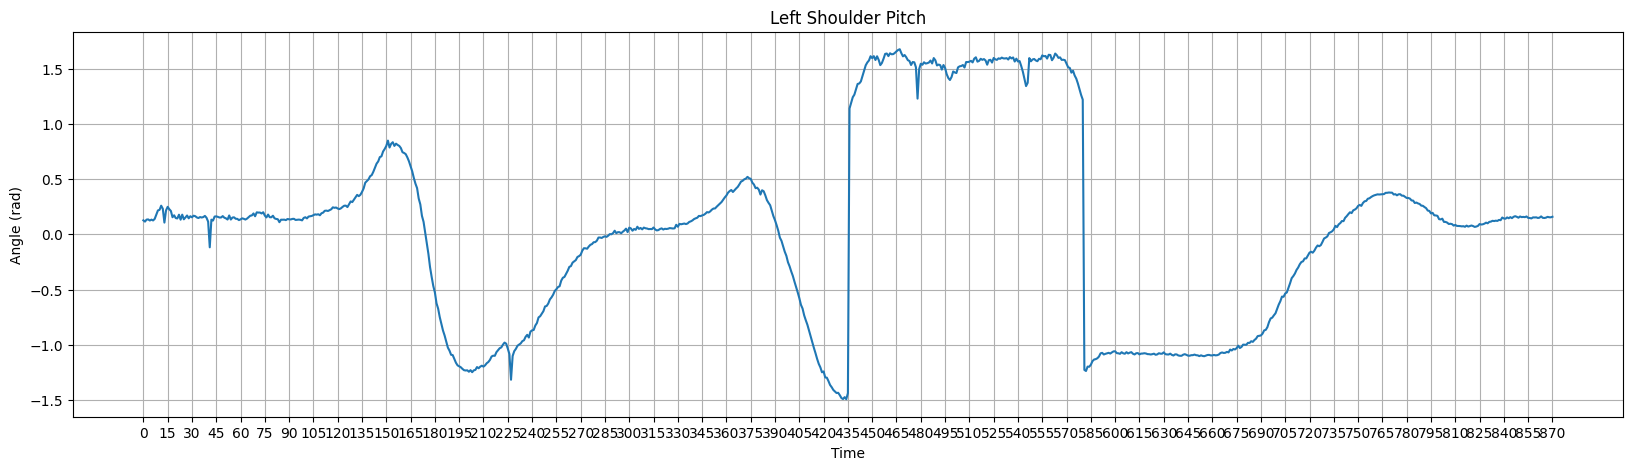

In [17]:
import numpy as np
# visualize data[:,15]
import matplotlib.pyplot as plt


#visualize angles[:, 15] and make the x-label finer
plt.figure(figsize=(20, 5))
plt.plot(angles[:, 15])
plt.title("Left Shoulder Pitch")
plt.xlabel("Time")
plt.ylabel("Angle (rad)")
plt.xticks(ticks=np.arange(0, angles.shape[0], step=15))
plt.grid()
plt.show()

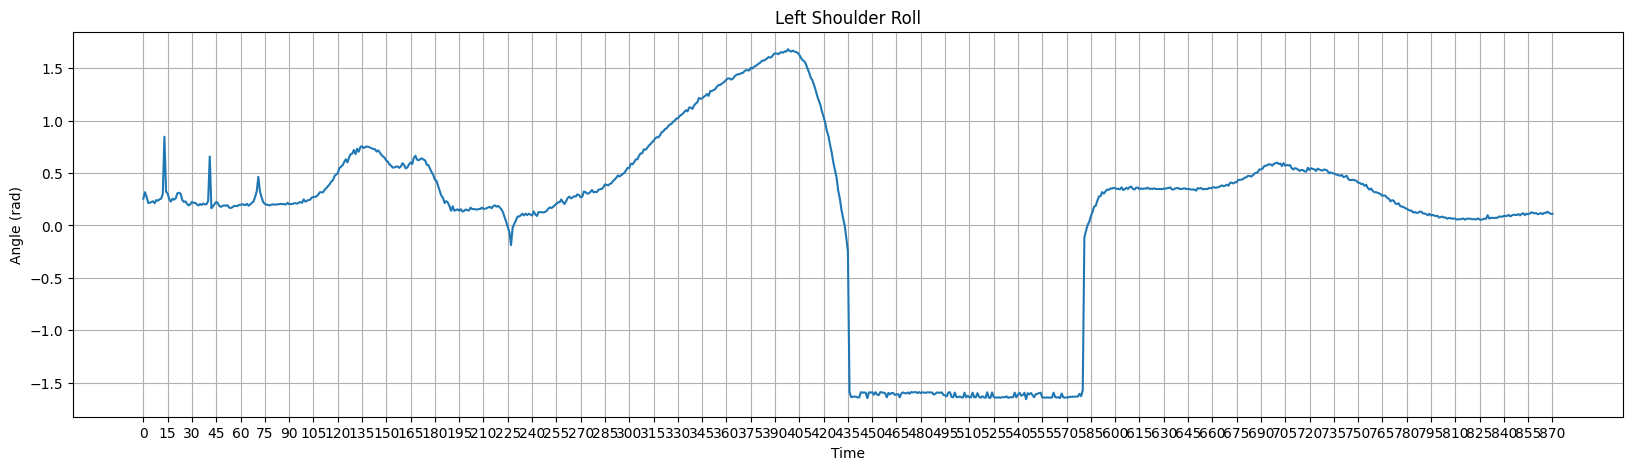

In [ ]:
import numpy as np
# visualize data[:,15]
import matplotlib.pyplot as plt


#visualize angles[:, 15] and make the x-label finer
plt.figure(figsize=(20, 5))
plt.plot(angles[:, 16])
plt.title("Left Shoulder Roll")
plt.xlabel("Time")
plt.ylabel("Angle (rad)")
plt.xticks(ticks=np.arange(0, angles.shape[0], step=15))
plt.grid()global_translation

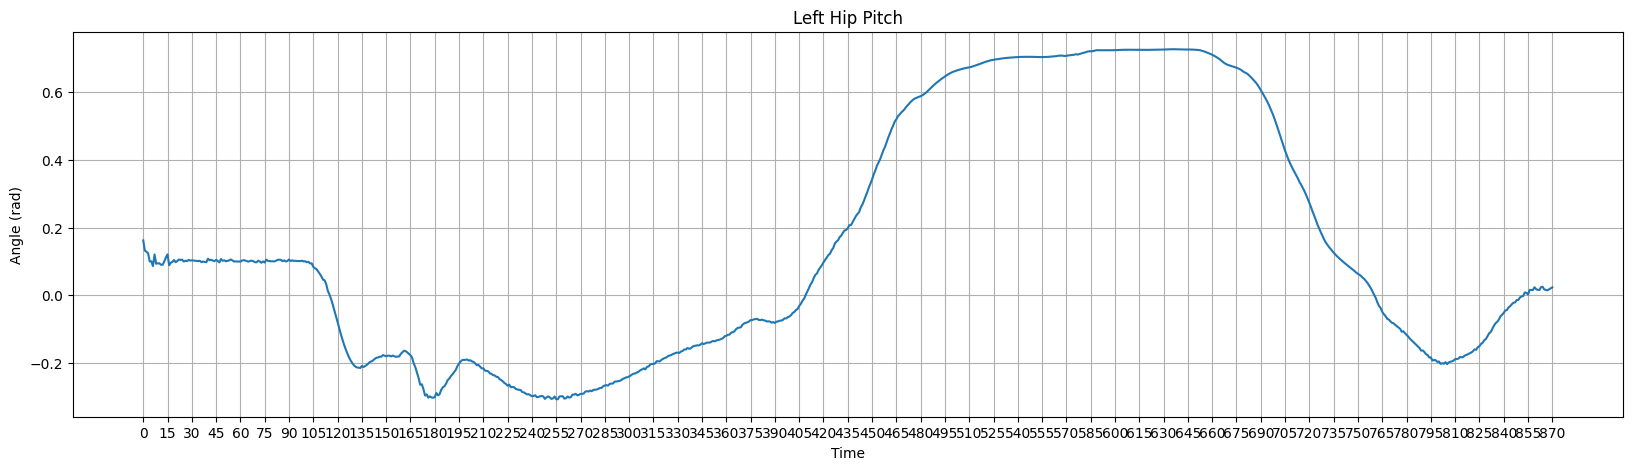

In [19]:
import numpy as np
# visualize data[:,15]
import matplotlib.pyplot as plt


#visualize angles[:, 0] and make the x-label finer
plt.figure(figsize=(20, 5))
plt.plot(angles[:, 0])
plt.title("Left Hip Pitch")
plt.xlabel("Time")
plt.ylabel("Angle (rad)")
plt.xticks(ticks=np.arange(0, angles.shape[0], step=15))
plt.grid()
plt.show()

In [ ]:
import numpy as np
# visualize data[:,15]
import matplotlib.pyplot as plt


#visualize angles[:, 0] and make the x-label finer
plt.figure(figsize=(20, 5))
plt.plot(angles[:, 0])
plt.title("Left Hip Pitch")
plt.xlabel("Time")
plt.ylabel("Angle (rad)")
plt.xticks(ticks=np.arange(0, angles.shape[0], step=15))
plt.grid()
plt.show()

In [4]:
global_rotation

array([[-0.00214519,  0.24779272],
       [ 0.05548396,  1.2973409 ],
       [ 0.9097191 , -0.36322904]], dtype=float32)

In [20]:
from HRI_retarget.utils.torch_utils.diff_quat import vec6d_to_matrix

rot_global = vec6d_to_matrix(torch.from_numpy(global_rotation))

In [15]:
rot = np.array([[0,-1,0],
                [1,0,0], 
                [0,0,1]])

In [16]:
rot_global @ rot

tensor([[ 0.1844,  0.0024, -0.9828],
        [ 0.9811, -0.0609,  0.1839],
        [-0.0594, -0.9981, -0.0135]], dtype=torch.float64)

In [21]:
import pickle

file_name = "/home/chenghuailin/hri-retargetting/data/motion/g1/motion_capture/Jappelio_rays_Skeleton_test6.pickle"
# open the file with pickle
with open(file_name, "rb") as f:
    data = pickle.load(f)

angles = data["angles"]
global_rotation = data["global_rotation"]
global_translation = data["global_translation"]
scale = data["scale"] 

vec6d_to_matrix(torch.from_numpy(global_rotation))

tensor([[ 0.9948, -0.1007, -0.0130],
        [ 0.1004,  0.9947, -0.0205],
        [ 0.0150,  0.0191,  0.9997]])